# Purpose of the notebook

We showed in the notebook "method_evaluation" that the best method for switchback test analysis it CRSE. In this notebook, we use the CRSE to calculate the confidence interval of the effect for different datasets. We start with data on country-level, move to city-level and finally analyse 4 "realistic dataset" on which we really would run a switchback test.

# Imports

In [1]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import seaborn as sns
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power
from tqdm import tqdm
import statsmodels.formula.api as smf
import pandas as pd
tqdm.pandas()

/Users/o.weisse/switchback_test_dag/venv/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


# Sample sizes (no. orders) per country in two weeks

In [2]:
client = bigquery.Client(project = 'logistics-data-staging-flat')

In [6]:
query = """
SELECT
entity_id,
count(*) number_of_orders
FROM `fulfillment-dwh-production.cl.orders_v2`orders
WHERE created_date BETWEEN "2023-05-01" AND "2023-05-14"
AND entity_id != "PH_MY" --this is not a valid entity id
GROUP BY entity_id
ORDER BY number_of_orders
"""

In [7]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/78 [00:00<?, ?rows/s]

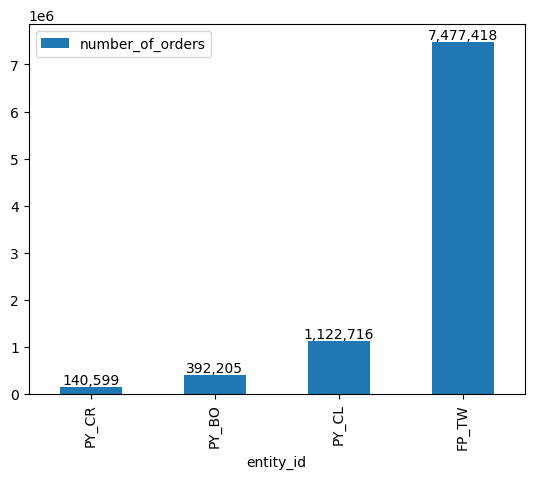

In [8]:
ax = data[data['entity_id'].isin(['FP_TW', "PY_CL", "PY_BO", "PY_CR", "PH_MY"])].set_index('entity_id').plot.bar()

# Add numbers above the bars
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',')), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

We have a very big difference in orders for different entities. Note that the number of orders for PY_CR and FP_TW is in different orders of magnitude.

# Download Data

In [3]:
def download_data(entity_ids, start_date, end_date):
    query = f"""
    SELECT
    entity_id,
    rider.city_id,
    created_date,
    created_at,
    orders.rider.timings.actual_delivery_time/60 delivery_time,
    orders.rider.timings.order_delay/60 order_delay,
    orders.rider.timings.bag_time/60 bag_time,
    --ARRAY(SELECT d.dropoff_distance_manhattan FROM UNNEST(orders.rider.deliveries) AS d)[OFFSET(0)] distance,
    FROM `fulfillment-dwh-production.cl.orders_v2`orders
    WHERE created_date BETWEEN "{start_date}" AND "{end_date}"
    AND entity_id in {tuple(entity_ids)}
    """

    bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
    data = client.query(query).result()\
    .to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')
    return data

In [7]:
entity_ids = ['FP_TW', "PY_CL", "PY_BO", "PY_CR", "PH_MY"]
start_date = "2023-05-01"
end_date = "2023-05-14"
data = download_data(entity_ids, start_date, end_date)

Downloading:   0%|          | 0/9158787 [00:00<?, ?rows/s]

In [4]:
KPI = "delivery_time"

In [9]:
# filter
data = data[data['delivery_time']<120]
data = data[data['delivery_time']>0]
data = data[data[KPI].notnull()]

<AxesSubplot:xlabel='delivery_time', ylabel='Density'>

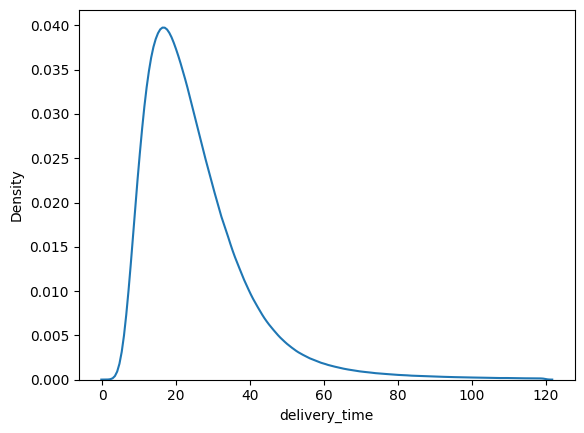

In [288]:
sns.kdeplot(data[KPI])

In [10]:
data[KPI].mean()

25.32630921140975

# Confidence Intervals per window size

In [3]:
def randomize_time_unit_assignment(data, proportion=0.5):
    """Creates a new columns called 'group'. Assigns each time unit randomly to either group A or B."""
    time_unit_group_dict = {i: np.random.choice(['A', 'B'], p=[1-proportion, proportion]) for i in data.time_unit.unique()}
    data['group'] = data['time_unit'].map(time_unit_group_dict)

In [4]:
def CRSE_CI(data, KPI):
    """Calculates the CI for cluster robust standard error method."""
    data["group_binary"] = data['group'].map({"A":0, "B": 1})
    model = smf.ols(formula=f'{KPI} ~ group_binary', data=data)
    results = model.fit(cov_type="cluster", cov_kwds={'groups': data['time_unit']})
    std_err = results.bse["group_binary"]
    mean_diff = results.params["group_binary"]
    return std_err, mean_diff

In [14]:
# assign to group with hourly switchback interval
data['time_unit'] = data['created_at'].dt.floor("1H")
randomize_time_unit_assignment(data)

In [15]:
# calculate CIs
results = data.groupby('entity_id').progress_apply(lambda data: 2*CRSE_CI(data, KPI)[0])
results.name = "CI"

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:06<00:00, 13.37s/it]


Text(0.5, 1.0, '95% confidence intervals for a 50:50 split on all orders')

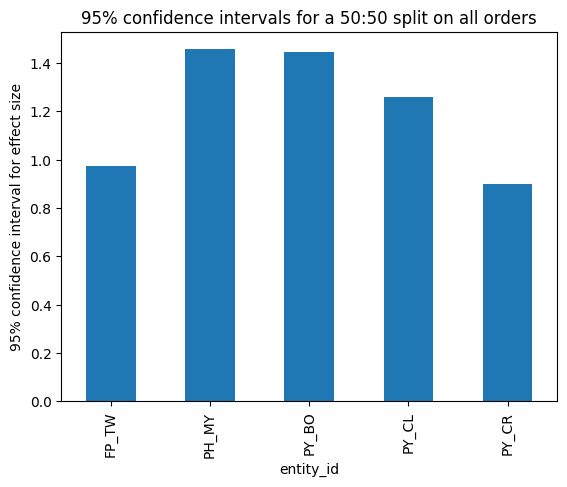

In [16]:
results.plot.bar()
plt.ylabel("95% confidence interval for effect size")
plt.title("95% confidence intervals for a 50:50 split on all orders")

Although we have many more orders for FP_TW than for PY_CR, we have a smaller CI for PY_CR.

In [17]:
mean_KPI = data.groupby('entity_id')['delivery_time'].mean()
mean_KPI.name = 'mean'
results = pd.concat([results, mean_KPI], axis=1)

We can also check the relative CI in the following plot.

Text(0.5, 1.0, '95% relative confidence intervals for a 50:50 split on all orders (in %)')

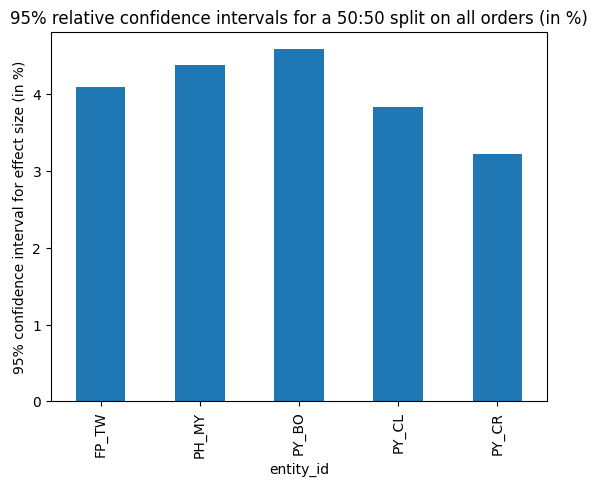

In [18]:
(100*(results['CI']/results['mean'])).plot.bar()
plt.ylabel("95% confidence interval for effect size (in %)")
plt.title("95% relative confidence intervals for a 50:50 split on all orders (in %)")

The following plot shows that the hourly fluctuation are bigger for TW than for CR. The learning from the example is that for switchback tests the number of orders is way less important than what the size of the fluctuations are.

In [19]:
grouped_data = data.groupby(['time_unit', 'entity_id'])[KPI].mean().unstack()

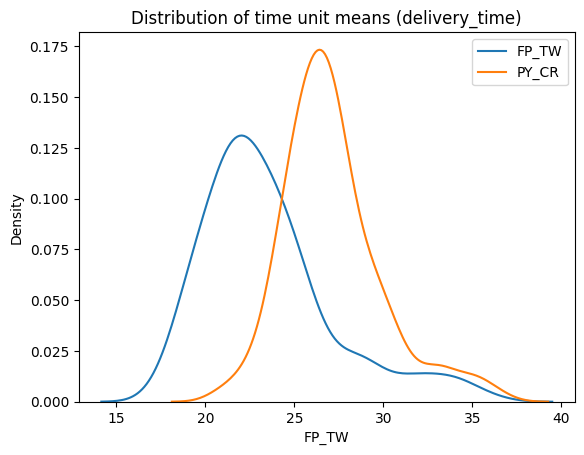

In [20]:
sns.kdeplot(grouped_data['FP_TW'])
sns.kdeplot(grouped_data['PY_CR'])
plt.title(f'Distribution of time unit means ({KPI})')
plt.legend(['FP_TW', "PY_CR"])

Text(0.5, 1.0, 'time unit means over time')

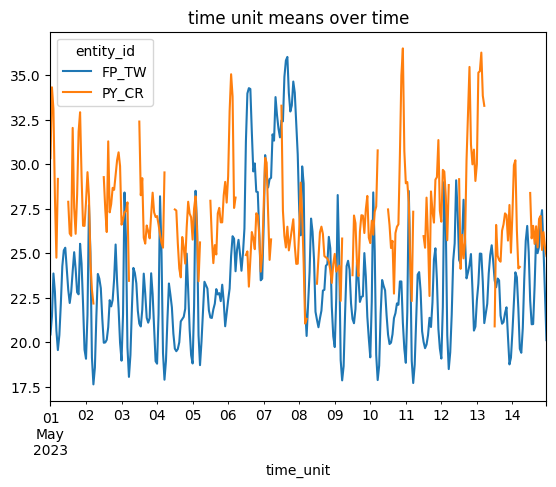

In [21]:
grouped_data[["FP_TW", "PY_CR"]].plot()
plt.title('DT (delivery time) time unit means over time')

# Increase length of test

In [274]:
entity_ids = ['FP_TW', "PY_CL", "PY_BO", "PY_CR", "PH_MY"]
start_date = "2023-05-01"
end_date = "2023-06-01"
data_long_test = download_data(entity_ids, start_date, end_date)

Downloading:   0%|          | 0/20681768 [00:00<?, ?rows/s]

In [275]:
# filter
data_long_test = data_long_test[data_long_test['delivery_time']<120]
data_long_test = data_long_test[data_long_test['delivery_time']>0]
data_long_test = data_long_test[data_long_test[KPI].notnull()]

In [276]:
# assign to group with hourly switchback interval
data_long_test['time_unit'] = data_long_test['created_at'].dt.floor("1H")
randomize_time_unit_assignment(data_long_test)

In [277]:
# calculate CIs
results = data_long_test.groupby('entity_id').progress_apply(lambda data: 2*CRSE_CI(data_long_test, KPI)[0])
results.name = "CI"

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:46<00:00, 33.23s/it]


Text(0.5, 1.0, '95% confidence intervals for a 50:50 split on all orders')

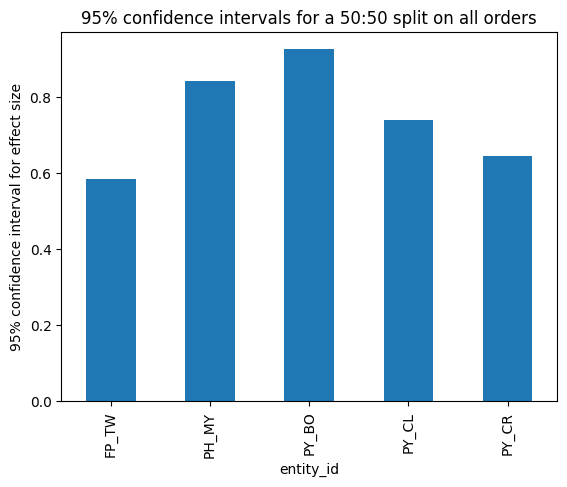

In [278]:
results.plot.bar()
plt.ylabel("95% confidence interval for effect size")
plt.title("95% confidence intervals for a 50:50 split on all orders")

In [279]:
mean_KPI = data_long_test.groupby('entity_id')['delivery_time'].mean()
mean_KPI.name = 'mean'
results = pd.concat([results, mean_KPI], axis=1)

Text(0.5, 1.0, '95% relative confidence intervals for a 50:50 split on all orders (in %)')

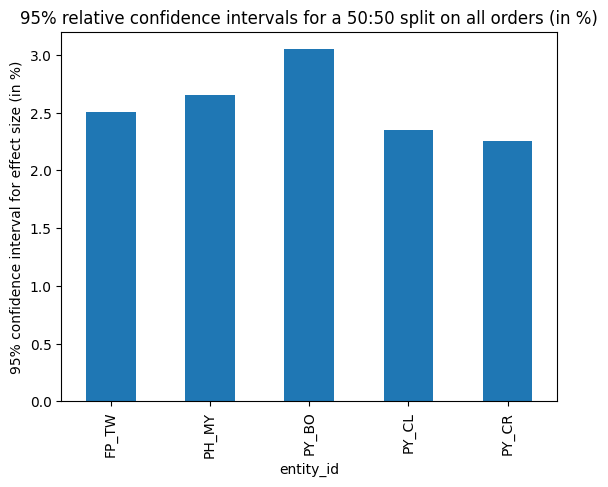

In [280]:
(100*(results['CI']/results['mean'])).plot.bar()
plt.ylabel("95% confidence interval for effect size (in %)")
plt.title("95% relative confidence intervals for a 50:50 split on all orders (in %)")

We can see that prolonging the length of the test is very effective to improve the sensitivity of the test.

# City level

In [27]:
# assign to group with hourly switchback interval
data['time_unit'] = data['created_at'].dt.floor("1H")
randomize_time_unit_assignment(data)

data['entity_city_id'] = data['entity_id']+data['city_id'].astype(str)

In [28]:
# calculate CIs
results = data.groupby('entity_city_id').progress_apply(lambda data: 2*CRSE_CI(data, KPI)[0])
results.name = "CI"

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:56<00:00,  1.39it/s]


Text(0.5, 1.0, '95% confidence intervals for a 50:50 split on all orders')

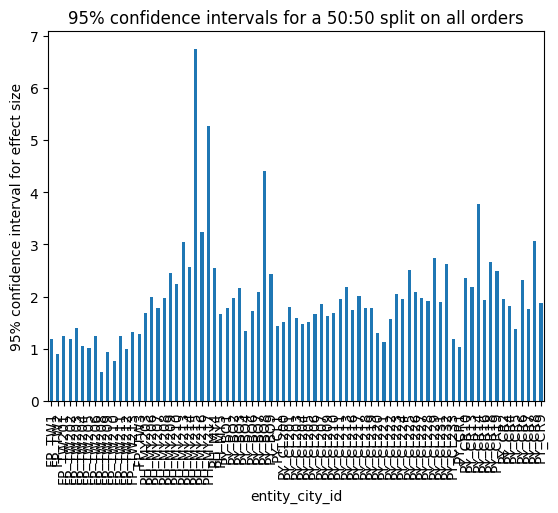

In [29]:
results.plot.bar()
plt.ylabel("95% confidence interval for effect size")
plt.title("95% confidence intervals for a 50:50 split on all orders")

In [32]:
mean_KPI = data.groupby('entity_city_id')['delivery_time'].mean()
mean_KPI.name = 'mean'
results = pd.concat([results, mean_KPI], axis=1)

Text(0.5, 1.0, '95% relative confidence intervals for a 50:50 split on all orders (in %)')

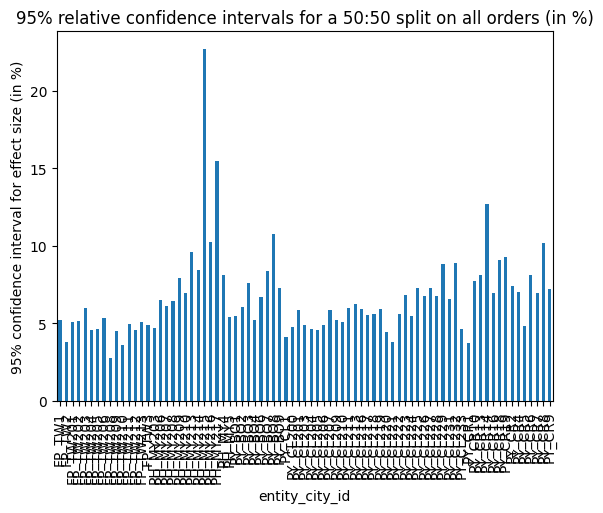

In [34]:
(100*(results['CI']/results['mean'])).plot.bar()
plt.ylabel("95% confidence interval for effect size (in %)")
plt.title("95% relative confidence intervals for a 50:50 split on all orders (in %)")

# Realistic datasets for surge test

We now move on to datasets on which we really might do a switchback test and report the confidence interval. In practise we want to measure an effect that is higher than the CI.

In [186]:
def preprocess_dataset(data):
    """Filters and converts values and does time unit assignment on hourly level"""
    original_length = len(data)
    data = data[data['actual_DT'].notnull()]
    data = data[data['delivery_distance_m'].notnull()]
    data['order_delay_clipped'] = np.clip(data['order_delay_mins'], 0, np.inf)
    data = data[data['order_delay_mins'].notnull()]
    new_length = len(data)
    print(f"Filtered out {100*(1-new_length/original_length)} % of the data")
    # assign to group with hourly switchback interval
    data['time_unit'] = data['order_placed_at'].dt.floor("1H")
    return data

In [187]:
def calculate_affected_orders(data):
    """Calculates how many orders are affected by surge. That is, how many have a surge fee > 0"""
    try:
        orders_not_affected = data['dps_surge_fee_eur'].astype(float).value_counts().loc[0.0]
    except:
        orders_not_affected = 0
    orders_total = data['dps_surge_fee_eur'].value_counts().sum()
    orders_affected = 1-orders_not_affected/orders_total
    return 100*orders_affected

## Cambodia - FP_KH, city Siem reap, zone Siem reap, ASA ID 5

In [188]:
query = """
SELECT
*
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
WHERE
entity_id = "FP_KH" AND assignment_id = 5 AND 
created_date BETWEEN "2023-06-11" AND "2023-07-11" 
AND vendor_price_scheme_type = "Automatic scheme"
"""

In [189]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data_KH = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/53925 [00:00<?, ?rows/s]

In [190]:
data_KH = preprocess_dataset(data_KH)
data_KH.name = 'FP_KH, Siem reap, Siem reap, ASA ID 5'

Filtered out 4.4598980064904925 % of the data


In [191]:
calculate_affected_orders(data_KH)

0.017468944099374717

## Laos - FP_LA, city Luang prabang, zone Luang prabang, ASA ID 6

In [192]:
query = """
SELECT
*
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
WHERE
entity_id = "FP_LA" AND assignment_id = 6 AND 
created_date BETWEEN "2023-01-01" AND "2023-02-01"
AND vendor_price_scheme_type = "Automatic scheme"
"""

In [193]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data_LA = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/12272 [00:00<?, ?rows/s]

In [194]:
data_LA = preprocess_dataset(data_LA)
data_LA.name = 'FP_LA, Luang prabang, ASA ID 6'

Filtered out 8.61310299869622 % of the data


In [195]:
calculate_affected_orders(data_LA)

40.534997770842615

# Philippines - Batangas, ASA IDs 181, 182, 274, 896

In [196]:
query = """
-- Batangas PH (Surge Component ID 84)
SELECT *
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
WHERE TRUE
  AND entity_id = "FP_PH"
  AND assignment_id IN (181, 182, 274, 896)
  AND created_date BETWEEN "2023-06-11" AND "2023-07-11"
  """

In [197]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data_PH1 = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/122124 [00:00<?, ?rows/s]

In [198]:
data_PH1 = preprocess_dataset(data_PH1)
data_PH1.name = 'FP_PH, Batangas, ASA IDs 181, 182, 274, 896'

Filtered out 6.62605220922996 % of the data


In [199]:
calculate_affected_orders(data_PH1)

3.6612529816191897

# Philippines - General Santos, ASA IDs 181, 182, 274, 896

In [200]:
query = """
SELECT *
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
WHERE TRUE
  AND entity_id = "FP_PH"
  AND assignment_id IN (165, 168)
  AND created_date BETWEEN "2023-06-11" AND "2023-07-11"
  """

In [201]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data_PH2 = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/26347 [00:00<?, ?rows/s]

In [202]:
data_PH2 = preprocess_dataset(data_PH2)
data_PH2.name = 'FP_PH, General Santos, ASA IDs 165, 168'

Filtered out 4.960716590124115 % of the data


In [203]:
calculate_affected_orders(data_PH2)

2.8714057507987167

# Philippines - Calamba, ASA IDs 100, 101

In [204]:
query = """
SELECT *
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
WHERE TRUE
  AND entity_id = "FP_PH"
  AND assignment_id IN (100, 101)
  AND created_date BETWEEN "2023-06-11" AND "2023-07-11"
  """

In [205]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data_PH3 = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/60909 [00:00<?, ?rows/s]

In [206]:
data_PH3 = preprocess_dataset(data_PH2)
data_PH3.name = 'FP_PH, Calamba, ASA IDs 100, 101'

Filtered out 0.0 % of the data


In [207]:
calculate_affected_orders(data_PH3)

2.8714057507987167

# Thailand - Bangkok, ASA IDs 1003, 1004, 1005, 1006, 1007, 1008, 1009, 439

In [208]:
query = """
-- Sub-groups within BKK TH (Surge Component ID 160)
SELECT *
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
WHERE TRUE
  AND entity_id = "FP_TH"
  AND assignment_id IN (1003, 1004, 1005, 1006, 1007, 1008, 1009, 439)
  AND created_date BETWEEN "2023-06-11" AND "2023-07-11"
  """

In [209]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data_TH1 = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/54490 [00:00<?, ?rows/s]

In [210]:
data_TH1 = preprocess_dataset(data_TH1)
data_TH1.name = 'FP_TH, Subgroup in Bangkok'

Filtered out 6.937052670214716 % of the data


In [211]:
calculate_affected_orders(data_TH1)

21.597318083218298

# Thailand - multiple cities, ASA IDs 1924, 1925

In [212]:
query = """
-- Special cities TH (Surge Component ID 268)
SELECT *
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
WHERE TRUE
  AND entity_id = "FP_TH"
  AND assignment_id IN (1924, 1925)
  AND created_date BETWEEN "2023-06-11" AND "2023-07-11"
  """

In [213]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data_TH2 = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/2130 [00:00<?, ?rows/s]

In [214]:
data_TH2 = preprocess_dataset(data_TH2)
data_TH2.name = 'FP_TH, Special cities, ASA IDs 1924, 1925'

Filtered out 4.084507042253516 % of the data


In [215]:
calculate_affected_orders(data_TH2)

2.104747919725891

# Thailand - Bangkok, ASA IDs 1922, 1923

In [216]:
query = """
-- Special Restos BKK TH (Surge Component ID 267)
SELECT *
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
WHERE TRUE
  AND entity_id = "FP_TH"
  AND assignment_id IN (1922, 1923)
  AND created_date BETWEEN "2023-06-11" AND "2023-07-11"
  """

In [217]:
bq_storage_client = bigquery_storage.BigQueryReadClient() # Instantiate a BQ storage client
data_TH3 = client.query(query).result()\
.to_dataframe(bqstorage_client = bq_storage_client, progress_bar_type = 'tqdm_notebook')

Downloading:   0%|          | 0/2623 [00:00<?, ?rows/s]

In [218]:
data_TH3 = preprocess_dataset(data_TH3)
data_TH3.name = 'FP_TH, Bangkok cities, ASA IDs 1922, 1923'

Filtered out 7.129241326725122 % of the data


In [219]:
calculate_affected_orders(data_TH3)

10.550082101806236

### Affected orders

In [220]:
datasets = [data_KH, data_LA, data_PH1, data_PH2, data_PH3, data_TH1, data_TH2, data_TH3]

In [221]:
affected_orders = []
for data in datasets:
    affected_orders.append(calculate_affected_orders(data))

Text(0.5, 1.0, '% of orders that are affected by surge (surge fee >0)')

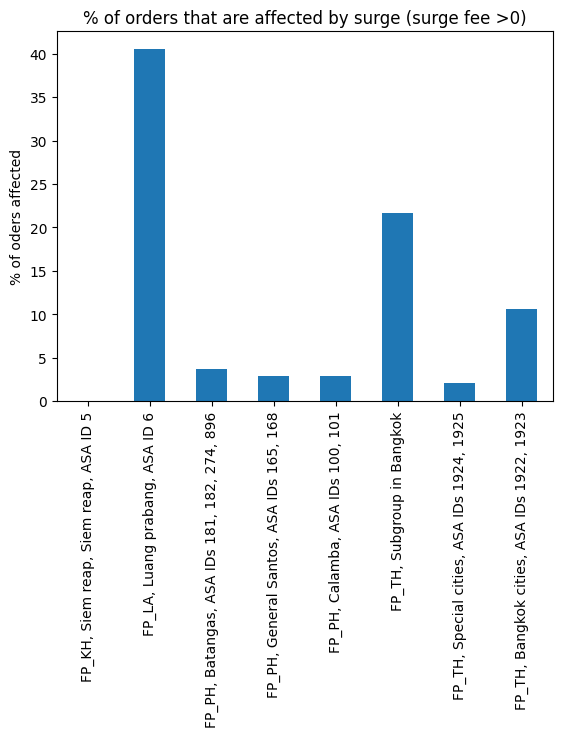

In [222]:
pd.Series(affected_orders, index=[data.name for data in datasets]).plot.bar(rot=90)
plt.ylabel("% of oders affected")
plt.title("% of orders that are affected by surge (surge fee >0)")

Text(0.5, 1.0, '% of orders affected FP_LA')

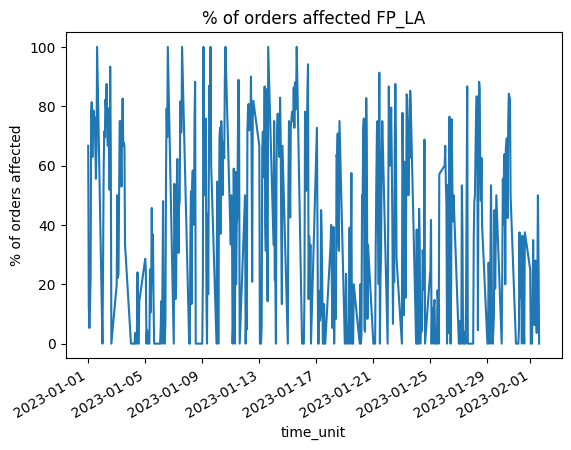

In [223]:
data_LA.groupby("time_unit").apply(calculate_affected_orders).plot()
plt.ylabel("% of orders affected")
plt.title("% of orders affected FP_LA")

Text(0.5, 1.0, '% of orders affected FP_PH Batangas')

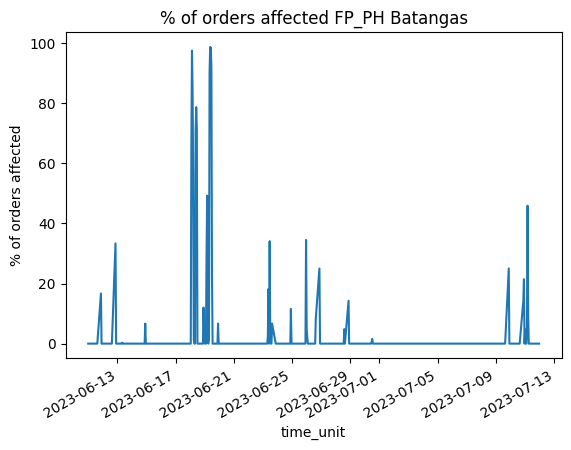

In [224]:
data_PH1.groupby("time_unit").apply(calculate_affected_orders).plot()
plt.ylabel("% of orders affected")
plt.title("% of orders affected FP_PH Batangas")

### Delivery Time

In [225]:
KPI = 'actual_DT'

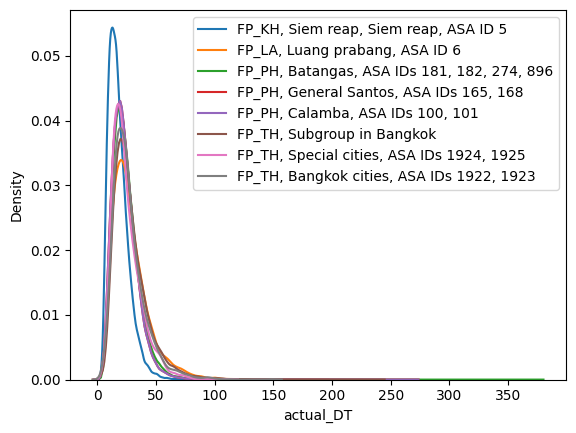

In [226]:
legend = []
for data in datasets:
    sns.kdeplot(data[KPI])
    legend.append(data.name)
plt.legend(legend)

In [227]:
def get_results(data, KPI):
    """Calculates the 95% CI for a chosen dataset and KPI. If we do not affect all orders, we need to multiply the
    CI by 1 over the proportion of orders that we affect."""
    randomize_time_unit_assignment(data, proportion=0.5)
    CI = 2*CRSE_CI(data, KPI)[0]
    
    CIs = []
    orders_affected_list = [50, 40, 30, 20, 10]
    for orders_affected in orders_affected_list:
        CIs.append(CI*100/orders_affected)
    results = pd.Series(CIs, index=[str(i)+"%" for i in orders_affected_list])
    return results

In [228]:
results = pd.DataFrame()
results_relative = pd.DataFrame()
for data in datasets:
    results[data.name] = get_results(data, KPI)
    results_relative[data.name] = 100*get_results(data, KPI)/data[KPI].mean()

Text(0.5, 0, '% of orders affected by surge')

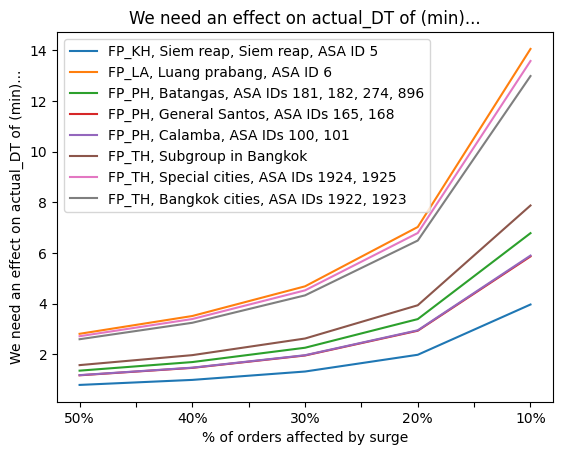

In [229]:
results.plot()
plt.title(f'We need an effect on {KPI} of (min)...')
plt.ylabel(f'We need an effect on {KPI} of (min)...')
plt.xlabel('% of orders affected by surge')

In [230]:
results

,"FP_KH, Siem reap, Siem reap, ASA ID 5","FP_LA, Luang prabang, ASA ID 6","FP_PH, Batangas, ASA IDs 181, 182, 274, 896","FP_PH, General Santos, ASA IDs 165, 168","FP_PH, Calamba, ASA IDs 100, 101","FP_TH, Subgroup in Bangkok","FP_TH, Special cities, ASA IDs 1924, 1925","FP_TH, Bangkok cities, ASA IDs 1922, 1923"
50%,0.793697,2.811839,1.357046,1.173372,1.180167,1.575702,2.716533,2.597652
40%,0.992121,3.514799,1.696308,1.466715,1.475208,1.969628,3.395666,3.247065
30%,1.322828,4.686398,2.261744,1.955620,1.966944,2.626170,4.527554,4.329421
20%,1.984241,7.029597,3.392616,2.933430,2.950417,3.939255,6.791332,6.494131
10%,3.968483,14.059195,6.785232,5.866860,5.900833,7.878510,13.582663,12.988262


Text(0.5, 0, '% of orders affected by surge')

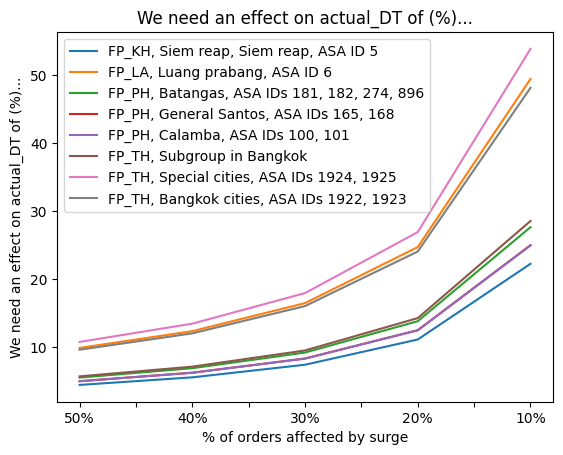

In [231]:
results_relative.plot()
plt.title(f'We need an effect on {KPI} of (%)...')
plt.ylabel(f'We need an effect on {KPI} of (%)...')
plt.xlabel('% of orders affected by surge')

In [232]:
results_relative

,"FP_KH, Siem reap, Siem reap, ASA ID 5","FP_LA, Luang prabang, ASA ID 6","FP_PH, Batangas, ASA IDs 181, 182, 274, 896","FP_PH, General Santos, ASA IDs 165, 168","FP_PH, Calamba, ASA IDs 100, 101","FP_TH, Subgroup in Bangkok","FP_TH, Special cities, ASA IDs 1924, 1925","FP_TH, Bangkok cities, ASA IDs 1922, 1923"
50%,4.455910,9.896165,5.533095,5.004263,4.995560,5.715399,10.779670,9.635314
40%,5.569887,12.370206,6.916369,6.255329,6.244451,7.144249,13.474588,12.044143
30%,7.426516,16.493609,9.221825,8.340439,8.325934,9.525665,17.966117,16.058857
20%,11.139775,24.740413,13.832737,12.510658,12.488901,14.288497,26.949176,24.088286
10%,22.279549,49.480826,27.665474,25.021316,24.977802,28.576994,53.898352,48.176571


### Distance

In [233]:
KPI = 'delivery_distance_m'

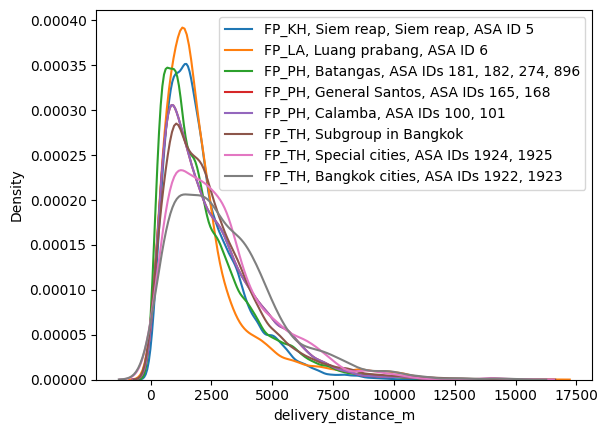

In [234]:
legend = []
for data in datasets:
    sns.kdeplot(data[KPI])
    legend.append(data.name)
plt.legend(legend)

In [235]:
results = pd.DataFrame()
results_relative = pd.DataFrame()
for data in datasets:
    results[data.name] = get_results(data, KPI)
    results_relative[data.name] = 100*get_results(data, KPI)/data[KPI].mean()

Text(0.5, 0, '% of orders affected by surge')

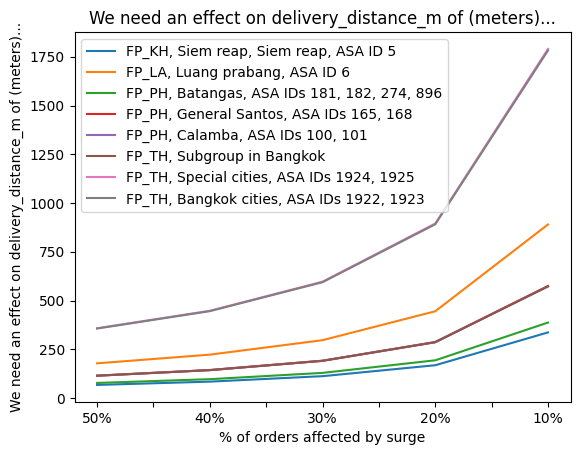

In [236]:
results.plot()
plt.title(f'We need an effect on {KPI} of (meters)...')
plt.ylabel(f'We need an effect on {KPI} of (meters)...')
plt.xlabel('% of orders affected by surge')

In [237]:
results

,"FP_KH, Siem reap, Siem reap, ASA ID 5","FP_LA, Luang prabang, ASA ID 6","FP_PH, Batangas, ASA IDs 181, 182, 274, 896","FP_PH, General Santos, ASA IDs 165, 168","FP_PH, Calamba, ASA IDs 100, 101","FP_TH, Subgroup in Bangkok","FP_TH, Special cities, ASA IDs 1924, 1925","FP_TH, Bangkok cities, ASA IDs 1922, 1923"
50%,67.314371,178.039982,77.416362,114.936101,114.613099,114.456500,358.038279,356.441649
40%,84.142964,222.549978,96.770452,143.670126,143.266374,143.070625,447.547849,445.552061
30%,112.190619,296.733304,129.027269,191.560168,191.021832,190.760833,596.730466,594.069414
20%,168.285928,445.099956,193.540904,287.340253,286.532748,286.141250,895.095699,891.104121
10%,336.571857,890.199912,387.081808,574.680505,573.065497,572.282500,1790.191397,1782.208243


Text(0.5, 0, '% of orders affected by surge')

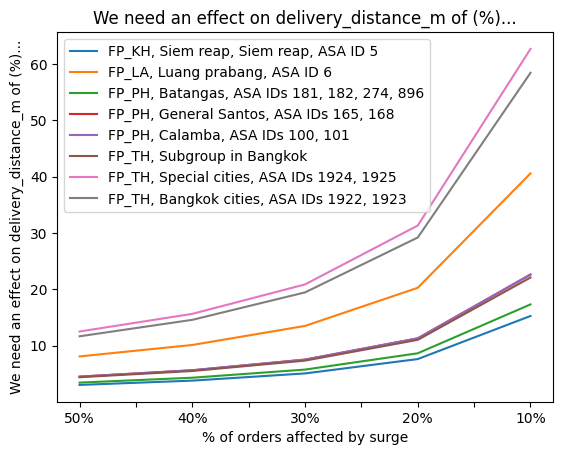

In [238]:
results_relative.plot()
plt.title(f'We need an effect on {KPI} of (%)...')
plt.ylabel(f'We need an effect on {KPI} of (%)...')
plt.xlabel('% of orders affected by surge')

In [239]:
results_relative

,"FP_KH, Siem reap, Siem reap, ASA ID 5","FP_LA, Luang prabang, ASA ID 6","FP_PH, Batangas, ASA IDs 181, 182, 274, 896","FP_PH, General Santos, ASA IDs 165, 168","FP_PH, Calamba, ASA IDs 100, 101","FP_TH, Subgroup in Bangkok","FP_TH, Special cities, ASA IDs 1924, 1925","FP_TH, Bangkok cities, ASA IDs 1922, 1923"
50%,3.057171,8.113855,3.467573,4.526002,4.528988,4.420730,12.529648,11.681232
40%,3.821463,10.142319,4.334467,5.657503,5.661236,5.525913,15.662060,14.601540
30%,5.095284,13.523092,5.779289,7.543337,7.548314,7.367883,20.882747,19.468721
20%,7.642927,20.284638,8.668933,11.315006,11.322471,11.051825,31.324120,29.203081
10%,15.285853,40.569276,17.337867,22.630012,22.644942,22.103650,62.648240,58.406162


### order delay

In [240]:
KPI = 'order_delay_clipped'

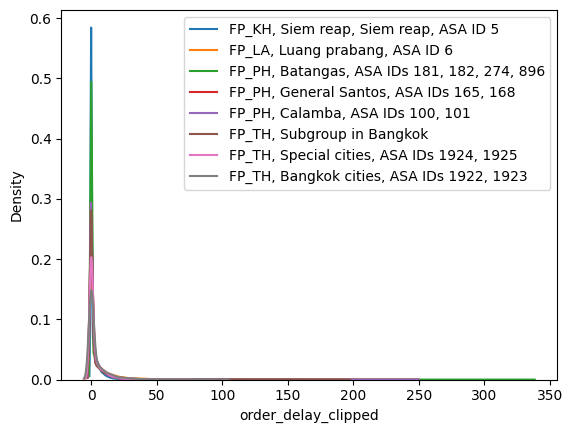

In [241]:
legend = []
for data in datasets:
    sns.kdeplot(data[KPI])
    legend.append(data.name)
plt.legend(legend)

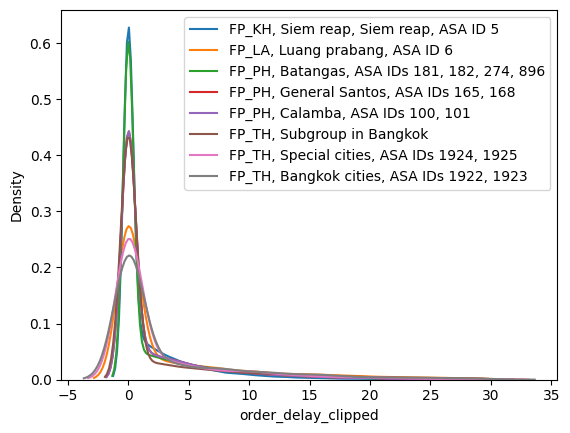

In [242]:
legend = []
for data in datasets:
    sns.kdeplot(data[data[KPI]<30][KPI])
    legend.append(data.name)
plt.legend(legend)

In [243]:
results = pd.DataFrame()
results_relative = pd.DataFrame()
for data in datasets:
    results[data.name] = get_results(data, KPI)
    results_relative[data.name] = 100*get_results(data, KPI)/data[KPI].mean()

Text(0.5, 0, '% of orders affected by surge')

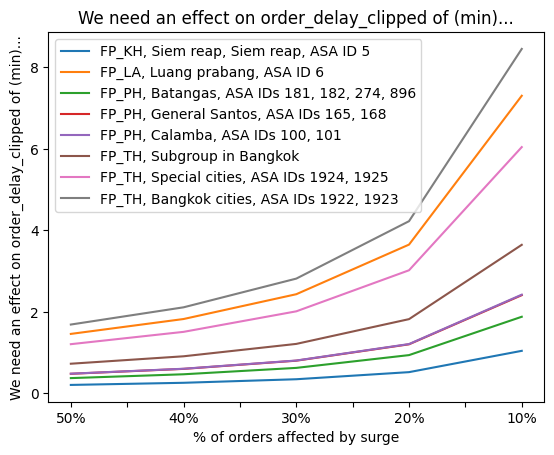

In [244]:
results.plot()
plt.title(f'We need an effect on {KPI} of (min)...')
plt.ylabel(f'We need an effect on {KPI} of (min)...')
plt.xlabel('% of orders affected by surge')

In [245]:
results

,"FP_KH, Siem reap, Siem reap, ASA ID 5","FP_LA, Luang prabang, ASA ID 6","FP_PH, Batangas, ASA IDs 181, 182, 274, 896","FP_PH, General Santos, ASA IDs 165, 168","FP_PH, Calamba, ASA IDs 100, 101","FP_TH, Subgroup in Bangkok","FP_TH, Special cities, ASA IDs 1924, 1925","FP_TH, Bangkok cities, ASA IDs 1922, 1923"
50%,0.209118,1.460989,0.376319,0.482282,0.484754,0.729384,1.209002,1.690810
40%,0.261397,1.826237,0.470399,0.602852,0.605942,0.911730,1.511253,2.113512
30%,0.348529,2.434982,0.627198,0.803803,0.807923,1.215640,2.015004,2.818017
20%,0.522794,3.652473,0.940797,1.205705,1.211885,1.823460,3.022506,4.227025
10%,1.045588,7.304946,1.881594,2.411410,2.423769,3.646921,6.045012,8.454050


Text(0.5, 0, '% of orders affected by surge')

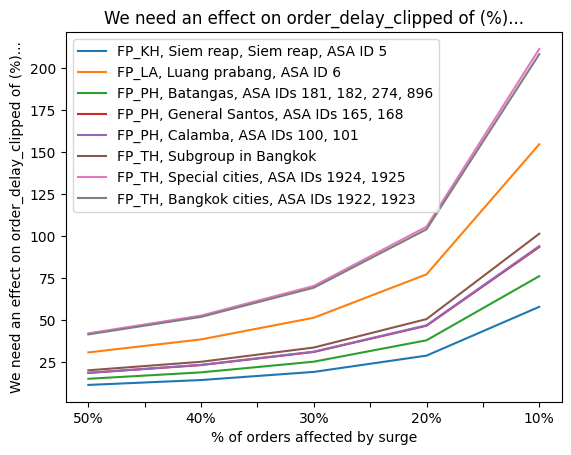

In [246]:
results_relative.plot()
plt.title(f'We need an effect on {KPI} of (%)...')
plt.ylabel(f'We need an effect on {KPI} of (%)...')
plt.xlabel('% of orders affected by surge')

In [247]:
results_relative

,"FP_KH, Siem reap, Siem reap, ASA ID 5","FP_LA, Luang prabang, ASA ID 6","FP_PH, Batangas, ASA IDs 181, 182, 274, 896","FP_PH, General Santos, ASA IDs 165, 168","FP_PH, Calamba, ASA IDs 100, 101","FP_TH, Subgroup in Bangkok","FP_TH, Special cities, ASA IDs 1924, 1925","FP_TH, Bangkok cities, ASA IDs 1922, 1923"
50%,11.611813,30.943259,15.260444,18.725881,18.835336,20.304516,42.287598,41.657032
40%,14.514766,38.679074,19.075556,23.407351,23.544169,25.380645,52.859498,52.071290
30%,19.353022,51.572099,25.434074,31.209802,31.392226,33.840860,70.479331,69.428387
20%,29.029532,77.358148,38.151111,46.814703,47.088339,50.761291,105.718996,104.142580
10%,58.059065,154.716297,76.302222,93.629406,94.176678,101.522581,211.437992,208.285160


# Best switchback intervals

We check for different KPIs what the best switchback interval is.

In [292]:
def get_CIs_for_different_window_sizes(data, KPI, window_sizes):
    """Calculates confidence intervals for a certain method for different specified window_sizes."""
    CIs = []
    for window_size in tqdm(window_sizes):
        data['time_unit'] = data['order_placed_at'].dt.floor(window_size)
        randomize_time_unit_assignment(data)
        CI, _ = CRSE_CI(data, KPI)
        CIs.append(2*CI)
    return pd.Series(CIs, index=window_sizes, name=data.name)

In [293]:
window_sizes = [str(i)+"H" for i in range(1,12)]+["1D", "2D", "3D"]

results = pd.DataFrame()

for KPI in ['actual_DT', 'delivery_distance_m', 'dps_mean_delay']:
    CIs = get_CIs_for_different_window_sizes(data_KH, KPI, window_sizes)
    results[KPI] = 100*CIs/data_KH[KPI].mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.50it/s]


Text(0.5, 1.0, 'Confidence Interval for effect (%) for different switchback intervals')

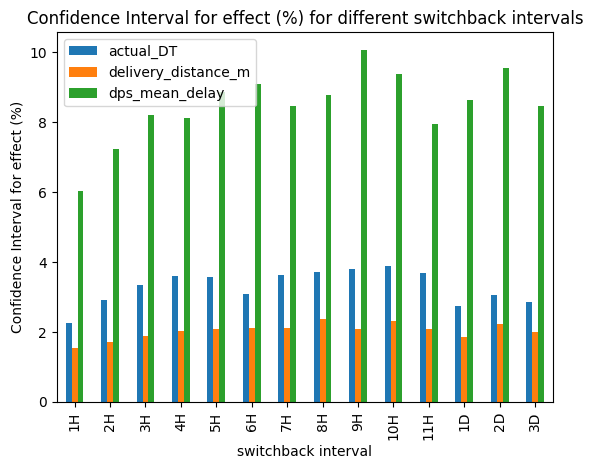

In [309]:
results.plot.bar()
plt.xlabel("switchback interval")
plt.ylabel("Confidence Interval for effect (%)")
plt.title("Confidence Interval for effect (%) for different switchback intervals")

Text(0.5, 1.0, 'CI for effect on DT (%) for different switchback intervals')

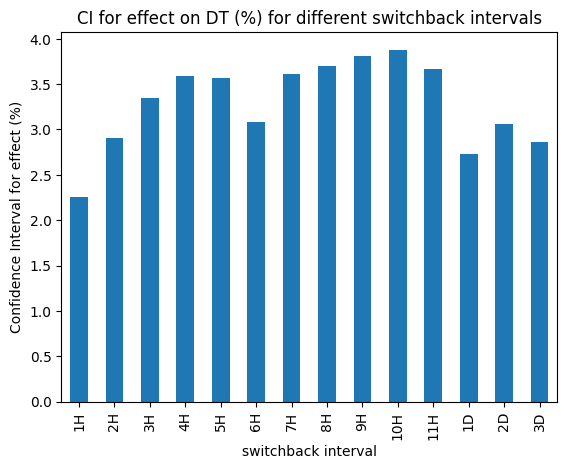

In [312]:
results['actual_DT'].plot.bar()
plt.xlabel("switchback interval")
plt.ylabel("Confidence Interval for effect (%)")
plt.title("CI for effect on DT (%) for different switchback intervals")

A lower switchback interval does not mean that we get a better CI. The size of the CI depends on the fluctuations that we have on the time unit level. This needs to be determined experimentally before a test. That being said, in all of the datasets that we analysed, the 1-hour switchback interval performed best.